In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

### Generate State Space

The state space is 2-dimensional, consisting of `num_concepts` different classes. Class $c_i$ is generated by sampling from a normal distribution $~\mathcal{N}(\mu_{c_i}, \sigma_{c_i})$. The concept of a class is assumed to be its mean $\mu_{c_i}$.

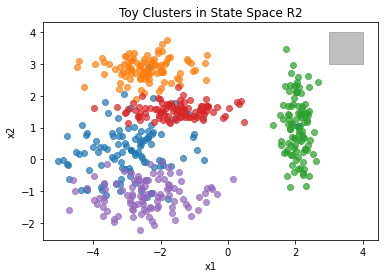

In [5]:
num_concepts = 5
examples_per_concept = 100

# Sample candidate class means from uniform distribution
x1 = np.random.uniform(-3, 3, num_concepts)
x2 = np.random.uniform(-3, 3, num_concepts)
means = np.stack((x1, x2), axis=1)

fig, ax = plt.subplots()
plt.scatter(x1, x2)

clusters = np.zeros((examples_per_concept*num_concepts, 2))
y = np.zeros(examples_per_concept*num_concepts)

for i in range(num_concepts):
    y[i*examples_per_concept: (i+1)*examples_per_concept] = i
    cov = [[np.random.uniform(0.01, 1), 0], [0, np.random.uniform(0.01, 1)]]
    x1, x2 = np.random.multivariate_normal(
        means[i], cov, size=examples_per_concept, check_valid='warn').T
    clusters[i*examples_per_concept: (i+1)*examples_per_concept] = np.stack((x1,x2), axis=1)
    plt.plot(x1, x2, 'o', alpha=0.7)

rect = patches.Rectangle([3, 3], 1, 1, fill=True, color="grey", alpha=0.5)
ax.add_patch(rect)

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Toy Clusters in State Space R2")
plt.show()


### Environment Dynamics

Suppose the goal of the agent is to reach the upper right corner our confined state space, a square located at (3,3). Let the reward of of all steps in which the goal is not achieved by -1. Additionally, suppose there is a $\textit{wind}$ acting in the negative $x$ direction, pushing the agent further from its goal. Suppose also that the agent experiences the wind more severely in certain regions of the state space; characterised by the concept classes in the dataset.

Let the action space comprise of 4 discrete actions: {up, down, right, left}

The transtition to the next state $T(s'|s)$ is given as
$ s_{t+1} = s_{t} + \Delta_{ss} \cdot a_t + w(s_t) $,
Where $\Delta_{ss}$ is a step size, $a_t$ is a unit vector representing the action and $w(s_t)$ is a function which describes the $\textit{wind severity experienced by the agent}$ given the current state. Intuitively, we may want to avoid certain states in reaching our goal, or at least know if taking some action might lead to problematic states.

A possible definition of $w(s_t)$. The severity of the $\textit{wind}$ in each cluster may be normally distributed around the center of the cluster, i.e. focused at the center. Then the severity for a given position in the state space could be represented by the sum severities sampled from each distribution weighted by the distance to the cluster centroid.

### Generate Trajectories and Behaviour Policy

During trajectory generation, we can assign a state to a concept/cluster possibly by its K nearest neighbours, or simply to the class of its closest centroid. Then for each time step in a trajectory, we will have a tuple $(s_i, a_i, r_{i+1}, c_i)$.

* How to define a behaviour policy? Example: Starting in the bottom right corner, move up and right with greater and probability of moving left and down respectively.

Reward: -44


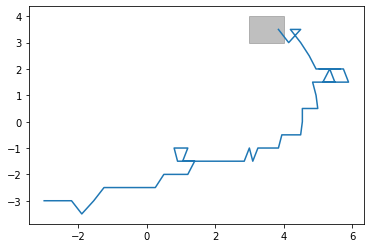

In [364]:
up = [0, 1]
down = [0, -1]
right = [1, 0]
left = [-1, 0]

SS = np.array([up, down, right, left])


def policy(state):
    indices = [0, 1, 2, 3]
    return SS[np.random.choice(indices, 1, p=[0.35, 0.15, 0.35, 0.15])[0]]


def reached_goal(s):
    return s[0] >= 3 and s[0] <= 4 and s[1] >= 3 and s[1] <= 4


def wind(s):
    return 0.1*s[1]*np.array(left)


T = 100

alpha = 0.5
history = []
s = [-3, -3]  # s0
history.append(s)
reward = 0

for t in range(1, T):
    action = policy(s)
    s = s + alpha*action + wind(s)  # transition
    history.append(s)
    if reached_goal(s):
        break
    reward -= 1

print(f"Reward: {reward}")
history = np.array(history)
fig, ax2 = plt.subplots()
plt.plot(history[:, 0], history[:, 1])
rect = patches.Rectangle([3, 3], 1, 1, fill=True, color="grey", alpha=0.5)
ax2.add_patch(rect)
plt.show()
